In [1]:
import os
os.getcwd()

'/home/9010'

In [2]:
os.listdir()

['.bash_logout',
 '.profile',
 '.bashrc',
 '.ssh',
 '.ipython',
 '.local',
 '.cache',
 '.bash_history',
 '.ipynb_checkpoints',
 '.docker',
 'Untitled.ipynb',
 '.config']

In [4]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
#import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

Using TensorFlow backend.


In [46]:
IMG_PATH = '/home/9010/Data/'
x=os.listdir(IMG_PATH)

In [54]:
IMG_PATH = '/home/9010/Data/'
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, '/home/9010/TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, '/home/9010/TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, '/home/9010/VAL/'+ CLASS.upper() + '/' + FILE_NAME)

In [58]:
TRAIN_DIR = '/home/9010/TRAIN/'
TEST_DIR = '/home/9010/TEST/'
VAL_DIR = '/home/9010/VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 3/3 [00:00<00:00, 21.53it/s]

{len(X)} images loaded from {dir_path} directory.
{len(X)} images loaded from {dir_path} directory.
{len(X)} images loaded from {dir_path} directory.


In [57]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print('{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [59]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [60]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

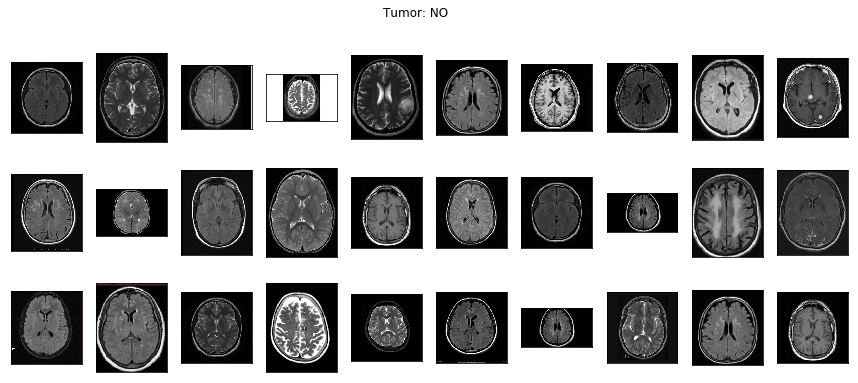

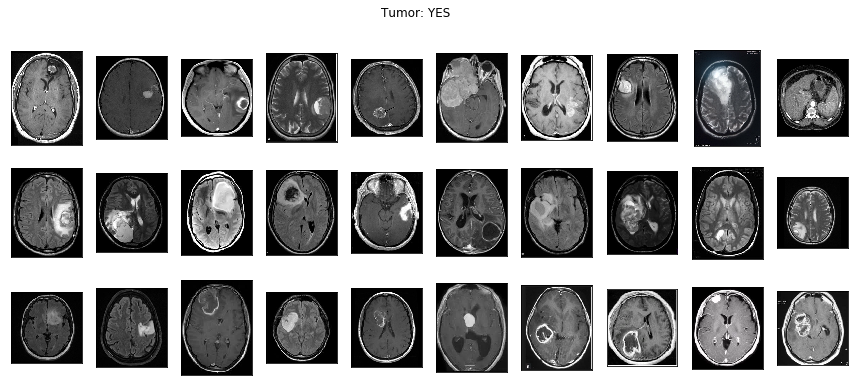

In [61]:
plot_samples(X_train, y_train, labels, 30)

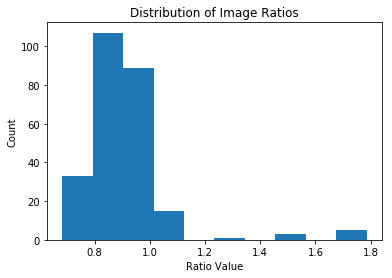

In [62]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

In [77]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [69]:
img = cv2.imread('/home/9010/Data/yes/Y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

In [67]:
# author:    Adrian Rosebrock
# website:   http://www.pyimagesearch.com

# import the necessary packages
import numpy as np
import cv2
import sys

# import any special Python 2.7 packages
if sys.version_info.major == 2:
    from urllib import urlopen

# import any special Python 3 packages
elif sys.version_info.major == 3:
    from urllib.request import urlopen

def translate(image, x, y):
    # define the translation matrix and perform the translation
    M = np.float32([[1, 0, x], [0, 1, y]])
    shifted = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

    # return the translated image
    return shifted

def rotate(image, angle, center=None, scale=1.0):
    # grab the dimensions of the image
    (h, w) = image.shape[:2]

    # if the center is None, initialize it as the center of
    # the image
    if center is None:
        center = (w // 2, h // 2)

    # perform the rotation
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))

    # return the rotated image
    return rotated

def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w / 2, h / 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))

def resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation=inter)

    # return the resized image
    return resized

def skeletonize(image, size, structuring=cv2.MORPH_RECT):
    # determine the area (i.e. total number of pixels in the image),
    # initialize the output skeletonized image, and construct the
    # morphological structuring element
    area = image.shape[0] * image.shape[1]
    skeleton = np.zeros(image.shape, dtype="uint8")
    elem = cv2.getStructuringElement(structuring, size)

    # keep looping until the erosions remove all pixels from the
    # image
    while True:
        # erode and dilate the image using the structuring element
        eroded = cv2.erode(image, elem)
        temp = cv2.dilate(eroded, elem)

        # subtract the temporary image from the original, eroded
        # image, then take the bitwise 'or' between the skeleton
        # and the temporary image
        temp = cv2.subtract(image, temp)
        skeleton = cv2.bitwise_or(skeleton, temp)
        image = eroded.copy()

        # if there are no more 'white' pixels in the image, then
        # break from the loop
        if area == area - cv2.countNonZero(image):
            break

    # return the skeletonized image
    return skeleton

def opencv2matplotlib(image):
    # OpenCV represents images in BGR order; however, Matplotlib
    # expects the image in RGB order, so simply convert from BGR
    # to RGB and return
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def url_to_image(url, readFlag=cv2.IMREAD_COLOR):
    # download the image, convert it to a NumPy array, and then read
    # it into OpenCV format
    resp = urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, readFlag)

    # return the image
    return image

def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)

    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)

    # return the edged image
    return edged

def grab_contours(cnts):
    # if the length the contours tuple returned by cv2.findContours
    # is '2' then we are using either OpenCV v2.4, v4-beta, or
    # v4-official
    if len(cnts) == 2:
        cnts = cnts[0]

    # if the length of the contours tuple is '3' then we are using
    # either OpenCV v3, v4-pre, or v4-alpha
    elif len(cnts) == 3:
        cnts = cnts[1]

    # otherwise OpenCV has changed their cv2.findContours return
    # signature yet again and I have no idea WTH is going on
    else:
        raise Exception(("Contours tuple must have length 2 or 3, "
            "otherwise OpenCV changed their cv2.findContours return "
            "signature yet again. Refer to OpenCV's documentation "
            "in that case"))

    # return the actual contours array
    return cnts

def is_cv2(or_better=False):
    # grab the OpenCV major version number
    major = get_opencv_major_version()

    # check to see if we are using *at least* OpenCV 2
    if or_better:
        return major >= 2

    # otherwise we want to check for *strictly* OpenCV 2
    return major == 2

def is_cv3(or_better=False):
    # grab the OpenCV major version number
    major = get_opencv_major_version()

    # check to see if we are using *at least* OpenCV 3
    if or_better:
        return major >= 3

    # otherwise we want to check for *strictly* OpenCV 3
    return major == 3

def is_cv4(or_better=False):
    # grab the OpenCV major version number
    major = get_opencv_major_version()

    # check to see if we are using *at least* OpenCV 4
    if or_better:
        return major >= 4

    # otherwise we want to check for *strictly* OpenCV 4
    return major == 4

def get_opencv_major_version(lib=None):
    # if the supplied library is None, import OpenCV
    if lib is None:
        import cv2 as lib

    # return the major version number
    return int(lib.__version__.split(".")[0])

def check_opencv_version(major, lib=None):
    # this function may be removed in a future release as we now
    # use the get_opencv_major_function to obtain the current OpenCV
    # version and then perform the actual version check *within* the
    # respective function
    import warnings
    message = """
        The check_opencv_version function is deprecated and may be
        removed in a future release. Use at your own risk.
    """
    warnings.warn(message, DeprecationWarning, stacklevel=2)
    
    # if the supplied library is None, import OpenCV
    if lib is None:
        import cv2 as lib
        
    # return whether or not the current OpenCV version matches the
    # major version number
    return lib.__version__.startswith(major)

def build_montages(image_list, image_shape, montage_shape):
    """
    ---------------------------------------------------------------------------------------------
    author: Kyle Hounslow
    ---------------------------------------------------------------------------------------------
    Converts a list of single images into a list of 'montage' images of specified rows and columns.
    A new montage image is started once rows and columns of montage image is filled.
    Empty space of incomplete montage images are filled with black pixels
    ---------------------------------------------------------------------------------------------
    :param image_list: python list of input images
    :param image_shape: tuple, size each image will be resized to for display (width, height)
    :param montage_shape: tuple, shape of image montage (width, height)
    :return: list of montage images in numpy array format
    ---------------------------------------------------------------------------------------------
    example usage:
    # load single image
    img = cv2.imread('lena.jpg')
    # duplicate image 25 times
    num_imgs = 25
    img_list = []
    for i in xrange(num_imgs):
        img_list.append(img)
    # convert image list into a montage of 256x256 images tiled in a 5x5 montage
    montages = make_montages_of_images(img_list, (256, 256), (5, 5))
    # iterate through montages and display
    for montage in montages:
        cv2.imshow('montage image', montage)
        cv2.waitKey(0)
    ----------------------------------------------------------------------------------------------
    """
    if len(image_shape) != 2:
        raise Exception('image shape must be list or tuple of length 2 (rows, cols)')
    if len(montage_shape) != 2:
        raise Exception('montage shape must be list or tuple of length 2 (rows, cols)')
    image_montages = []
    # start with black canvas to draw images onto
    montage_image = np.zeros(shape=(image_shape[1] * (montage_shape[1]), image_shape[0] * montage_shape[0], 3),
                          dtype=np.uint8)
    cursor_pos = [0, 0]
    start_new_img = False
    for img in image_list:
        if type(img).__module__ != np.__name__:
            raise Exception('input of type {} is not a valid numpy array'.format(type(img)))
        start_new_img = False
        img = cv2.resize(img, image_shape)
        # draw image to black canvas
        montage_image[cursor_pos[1]:cursor_pos[1] + image_shape[1], cursor_pos[0]:cursor_pos[0] + image_shape[0]] = img
        cursor_pos[0] += image_shape[0]  # increment cursor x position
        if cursor_pos[0] >= montage_shape[0] * image_shape[0]:
            cursor_pos[1] += image_shape[1]  # increment cursor y position
            cursor_pos[0] = 0
            if cursor_pos[1] >= montage_shape[1] * image_shape[1]:
                cursor_pos = [0, 0]
                image_montages.append(montage_image)
                # reset black canvas
                montage_image = np.zeros(shape=(image_shape[1] * (montage_shape[1]), image_shape[0] * montage_shape[0], 3),
                                      dtype=np.uint8)
                start_new_img = True
    if start_new_img is False:
        image_montages.append(montage_image)  # add unfinished montage
    return image_montages


def adjust_brightness_contrast(image, brightness=0., contrast=0.):
    """
    Adjust the brightness and/or contrast of an image
    :param image: OpenCV BGR image
    :param contrast: Float, contrast adjustment with 0 meaning no change
    :param brightness: Float, brightness adjustment with 0 meaning no change
    """
    beta = 0
    # See the OpenCV docs for more info on the `beta` parameter to addWeighted
    # https://docs.opencv.org/3.4.2/d2/de8/group__core__array.html#gafafb2513349db3bcff51f54ee5592a19
    return cv2.addWeighted(image,
                           1 + float(contrast) / 100.,
                           image,
                           beta,
                           float(brightness))

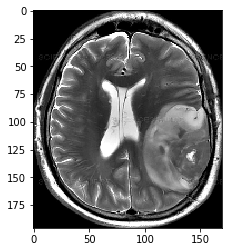

In [72]:
plt.imshow(new_img)

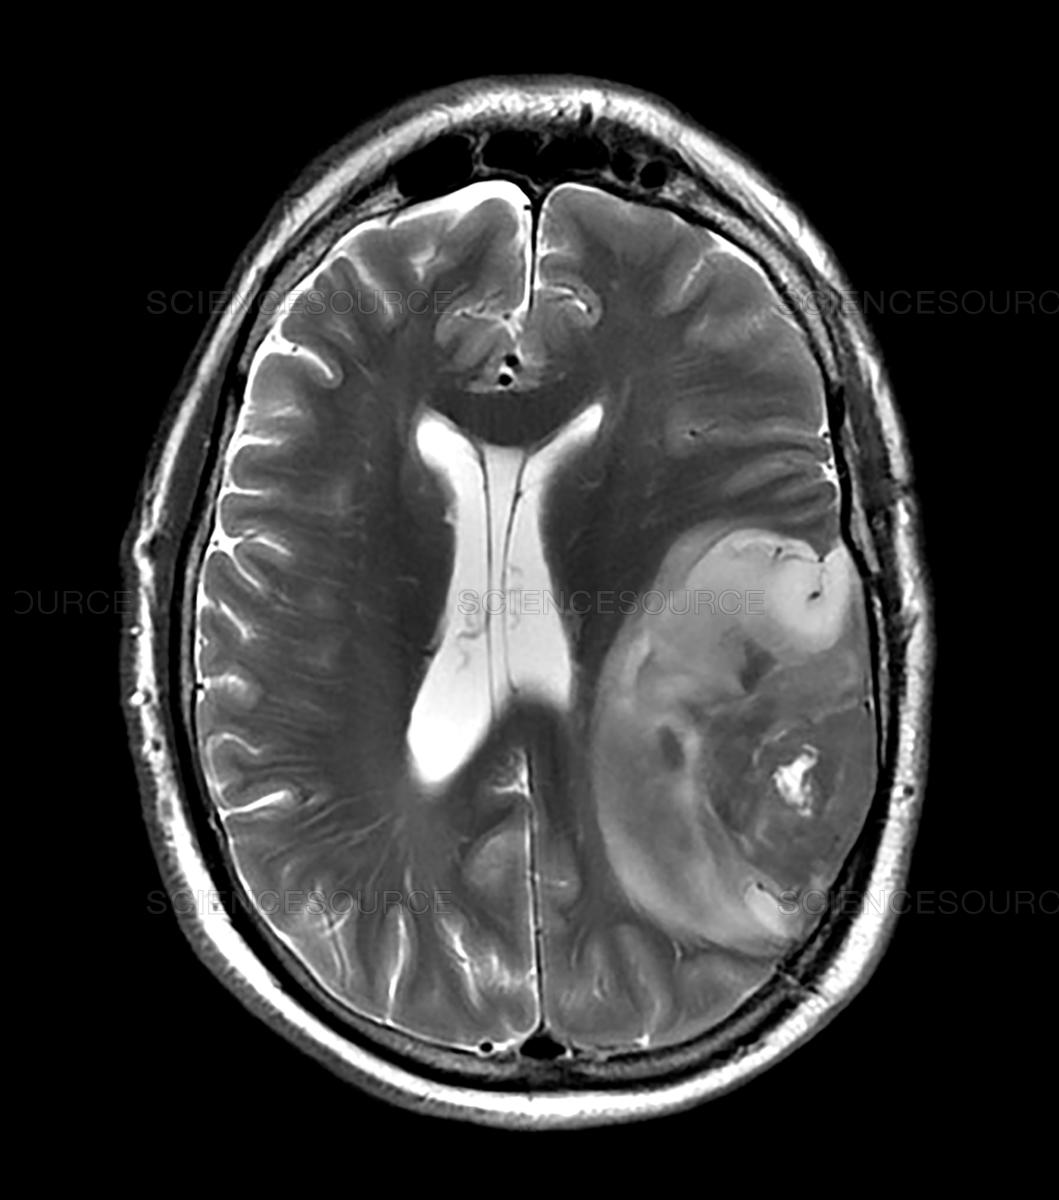

In [75]:
from IPython.display import Image
Image(filename='/home/9010/Data/yes/Y108.jpg',width=200) 

In [78]:
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

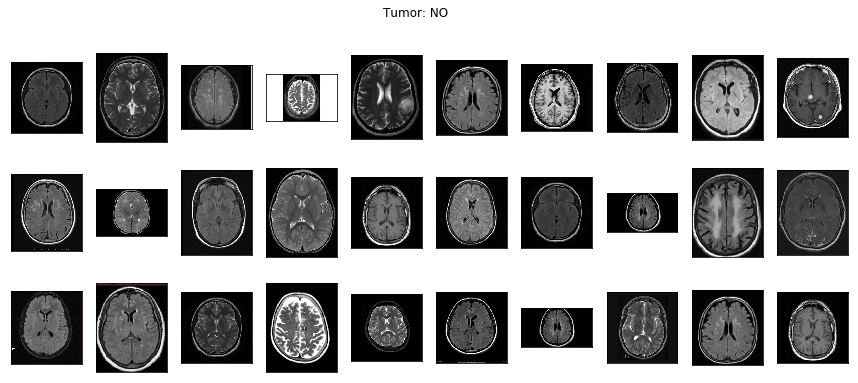

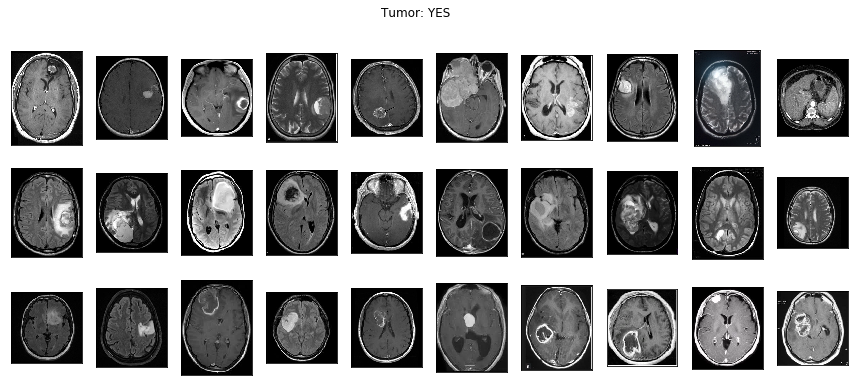

In [79]:
plot_samples(X_train, y_train, labels, 30)

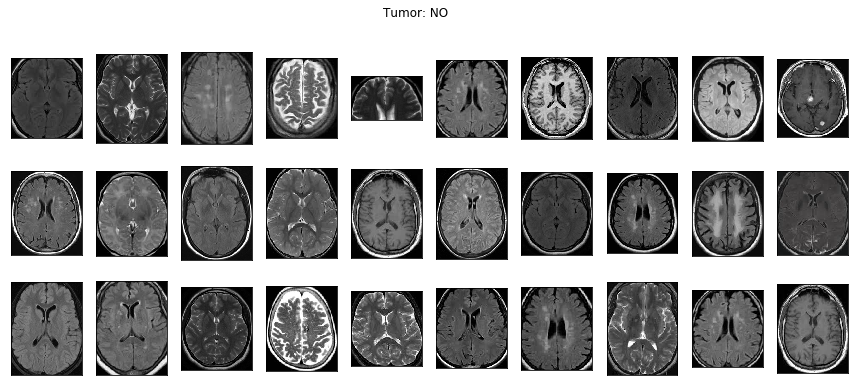

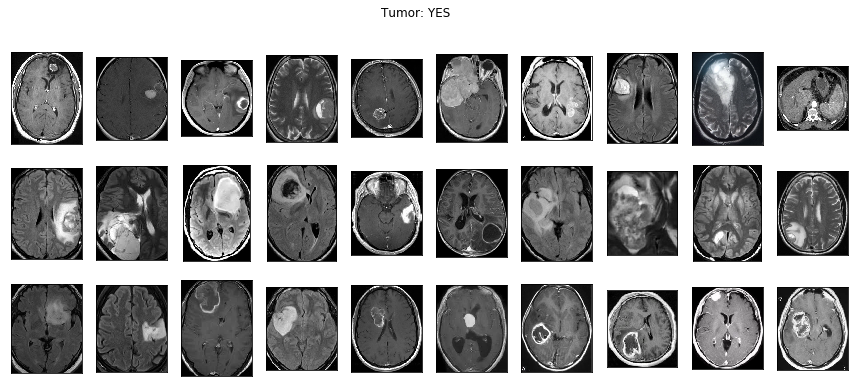

In [83]:
plot_samples(X_train_crop, y_train, labels, 30)

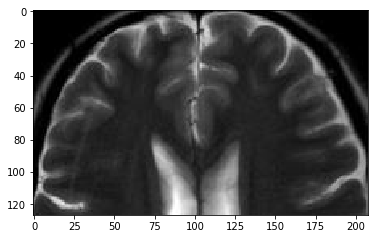

In [87]:
plt.imshow(X_train_crop[4])

In [89]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [91]:
# saving new images to the folder
#!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

In [92]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [93]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

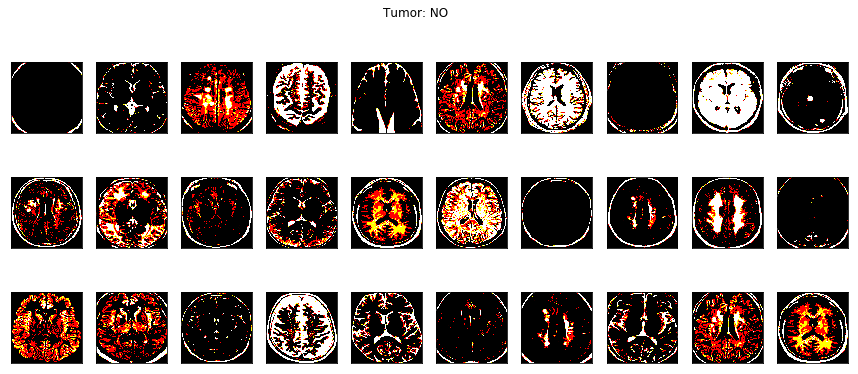

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

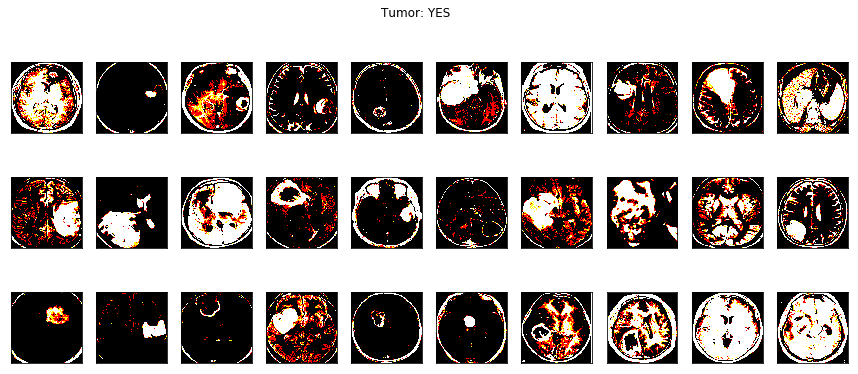

In [94]:
plot_samples(X_train_prep, y_train, labels, 30)

In [95]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [96]:
os.mkdir('preview')
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 

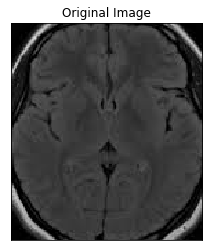

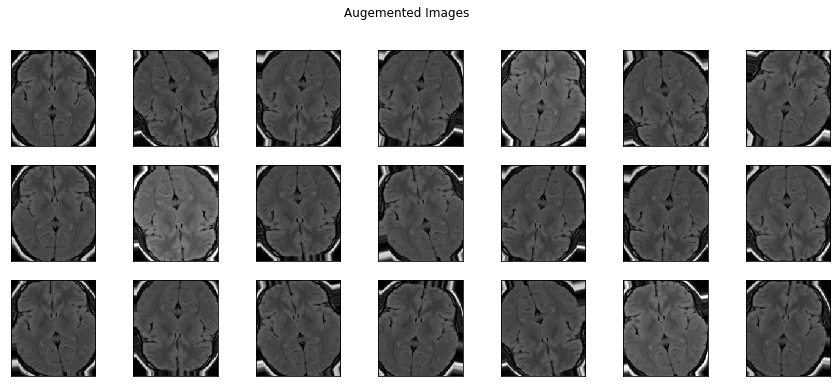

In [97]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [98]:
!rm -rf preview/

In [99]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [100]:
vgg16_weight_path = '/home/9010/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(
    weights=vgg16_weight_path,
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [101]:
NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [107]:
EPOCHS = 1
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=6
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=10,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

Epoch 1/1
10/10 [==============================] - 305s 31s/step - loss: 2.3040 - accuracy: 0.7558 - val_loss: 2.4266 - val_accuracy: 0.7785
